In [21]:
from transformers import CLIPModel, CLIPProcessor

# Load the pretrained CLIP model and processor
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_model.eval()  # Set the model to evaluation mode
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")


/home/azureuser/anaconda3/envs/dat_test/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1614: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [1]:
import pandas as pd
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch
import numpy as np
from tqdm import tqdm  # Ensure you have tqdm imported

class CustomDataset(Dataset):
    def __init__(self, images_dir, captions_file):
        self.images_dir = images_dir
        self.captions_df = pd.read_csv(captions_file)
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.4815, 0.4578, 0.4082], std=[0.2686, 0.2613, 0.2758])
        ])

    def __len__(self):
        return len(self.captions_df)

    def __getitem__(self, idx):
        image_filename = str(self.captions_df.iloc[idx]["saved_image"]).strip()
        caption = str(self.captions_df.iloc[idx]["title"]).strip()
        
        image_path = os.path.join(self.images_dir, image_filename)
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image file {image_path} not found.")

        image = Image.open(image_path).convert("RGB")
        image = self.transform(image)
        
        return {'image': image, 'caption': caption}

# Paths
images_dir = '/home/azureuser/dat/test/pytorch-stable-diffusion/Stable_difusion/sd'  # Specify your images directory
captions_file = '/home/azureuser/dat/test/pytorch-stable-diffusion/Stable_difusion/sd/dataset/data_with_images.csv'

# Initialize dataset and dataloader
dataset = CustomDataset(images_dir=images_dir, captions_file=captions_file)
#dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [2]:
import torch
from torch.utils.data import random_split, DataLoader
from sklearn.model_selection import train_test_split  # Optional if using the sklearn method

# Define dataset size and split ratio
dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)  # 80% for training
test_size = dataset_size - train_size  # 20% for testing

# Split dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders for training and test datasets
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Example to verify the splits
print(f"Total samples: {dataset_size}, Training samples: {train_size}, Test samples: {test_size}")


Total samples: 897, Training samples: 717, Test samples: 180


In [3]:
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
from transformers import CLIPModel, CLIPProcessor
from decoder_build import Diffusion

# Load the pretrained CLIP model and processor
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to("cuda")
clip_model.eval()  # Set the model to evaluation mode
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

def save_checkpoint(model, optimizer, epoch, best_val_loss, checkpoint_path):
    # Save the model state dictionary, optimizer state, epoch, and best validation loss
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'best_val_loss': best_val_loss
    }, checkpoint_path)

def save_losses_to_file(epoch, avg_train_loss, avg_val_loss, file_path, lr):
    with open(file_path, 'a') as file:
        file.write(f"Epoch {epoch}, Average Training Loss: {avg_train_loss:.4f}, Average Validation Loss: {avg_val_loss:.4f}, lr: {lr:.12f}\n")

def load_checkpoint(model, optimizer, checkpoint_path):
    # Load the checkpoint
    checkpoint = torch.load(checkpoint_path)
    
    # Load model and optimizer state dictionaries
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    # Load epoch and best validation loss
    epoch = checkpoint['epoch']
    best_val_loss = checkpoint['best_val_loss']
    
    return model, optimizer, epoch, best_val_loss

def compute_loss(outputs, targets):
    # Define your loss function here
    # Example placeholder function (use your actual loss function)
    loss_fn = torch.nn.MSELoss()  # Example: Mean Squared Error Loss
    return loss_fn(outputs, targets)

diffusion = Diffusion("cuda").to("cuda")
optimizer = AdamW(
    diffusion.parameters(),  # Các tham số của mô hình sẽ được tối ưu hóa
    lr=1e-4,                # Tốc độ học
    eps=1e-8,               # Hằng số epsilon
    betas=(0.9, 0.999),     # Các hệ số beta
    weight_decay=0.01       # Điều chỉnh trọng số
)

# Initialize the ReduceLROnPlateau scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)

def train(diffusion, train_loader, val_loader, clip_model, processor, optimizer, start_epoch, best_val_loss, num_epochs=10, device="cuda"):
    scaler = GradScaler()  # For mixed precision training
    diffusion.to(device).train()  # Set the diffusion model to training mode
    losses_file_path = "/home/azureuser/dat/test/pytorch-stable-diffusion/Stable_difusion/sd/checkpoint/losses_new.txt"  # Define path to save losses

    for epoch in range(start_epoch, num_epochs):
        diffusion.train()  # Set the diffusion model to training mode
        train_loss = 0.0

        # Training loop
        for batch_idx, batch in enumerate(tqdm(train_loader)):
            images = batch['image'].to(device)
            captions = batch['caption']

            # Process captions using CLIPProcessor
            inputs = processor(text=captions, return_tensors="pt", padding=True, truncation=True).to(device)
            captions_tensor = inputs['input_ids']

            with torch.no_grad():  # Disable gradient computation
                image_embeds = clip_model.get_image_features(images)  # Shape: [batch_size, embed_dim]
                text_embeds = clip_model.get_text_features(captions_tensor)  # Shape: [batch_size, embed_dim]

            optimizer.zero_grad()

            with autocast():
                # Forward pass
                outputs = diffusion(image_embeds, text_embeds)
                loss = compute_loss(outputs, images)  # Replace with your actual loss function
            
            # Backward pass and optimization
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()
        # Average training loss
        avg_train_loss = train_loss / len(train_loader)
        if epoch % 10 == 0:
            checkpoint_path = f"/home/azureuser/dat/test/pytorch-stable-diffusion/Stable_difusion/sd/checkpoint/checkpoint_epoch_{epoch + 1}_train_loss_{avg_train_loss:.4f}.pth"
            save_checkpoint(diffusion, optimizer, epoch + 1, avg_train_loss, checkpoint_path)
        print(f"Epoch {epoch + 1}, Average Training Loss: {avg_train_loss:.4f}")

        # Validation loop
        diffusion.eval()  # Set model to evaluation mode
        val_loss = 0.0

        with torch.no_grad():
            for batch_idx, batch in enumerate(val_loader):
                images = batch['image'].to(device)
                captions = batch['caption']

                # Process captions using CLIPProcessor
                inputs = processor(text=captions, return_tensors="pt", padding=True, truncation=True).to(device)
                captions_tensor = inputs['input_ids']

                image_embeds = clip_model.get_image_features(images)  # Shape: [batch_size, embed_dim]
                text_embeds = clip_model.get_text_features(captions_tensor)  # Shape: [batch_size, embed_dim]

                # Forward pass
                outputs = diffusion(image_embeds, text_embeds)
                loss = compute_loss(outputs, images)  # Replace with your actual loss function

                val_loss += loss.item()

        # Average validation loss
        avg_val_loss = val_loss / len(val_loader)
        print(f"Epoch {epoch + 1}, Average Validation Loss: {avg_val_loss:.4f}")

        # Print learning rate
        lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch + 1}, Learning Rate: {lr:.12f}")

        # Save losses to file
        save_losses_to_file(epoch + 1, avg_train_loss, avg_val_loss, losses_file_path, lr)

        # Check if the validation loss improved
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            checkpoint_path = f"/home/azureuser/dat/test/pytorch-stable-diffusion/Stable_difusion/sd/checkpoint/checkpoint_epoch_{epoch + 1}_val_loss_{best_val_loss:.4f}.pth"
            save_checkpoint(diffusion, optimizer, epoch + 1, best_val_loss, checkpoint_path)

        # Step the scheduler
        scheduler.step(avg_val_loss)

    # Save the final checkpoint
    final_checkpoint_path = f"/home/azureuser/dat/test/pytorch-stable-diffusion/Stable_difusion/sd/checkpoint/checkpoint_epoch_{num_epochs}_val_loss_{best_val_loss:.4f}.pth"
    save_checkpoint(diffusion, optimizer, num_epochs, best_val_loss, final_checkpoint_path)

# Example usage:
# Initialize your train and validation dataloaders
# train_loader = DataLoader(...)
# val_loader = DataLoader(...)

# Load checkpoint if needed
#checkpoint_path = '/home/azureuser/dat/test/pytorch-stable-diffusion/Stable_difusion/sd/checkpoint/checkpoint_epoch_21_train_loss_0.6715.pth'
#diffusion, optimizer, start_epoch, best_val_loss = load_checkpoint(diffusion, optimizer, checkpoint_path)

# Train the model
train(diffusion, train_loader, test_loader, clip_model, processor, optimizer, start_epoch=0, best_val_loss=99, num_epochs=100, device="cuda")


/home/azureuser/anaconda3/envs/dat_test/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/home/azureuser/anaconda3/envs/dat_test/lib/python3.10/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/azureuser/anaconda3/envs/dat_test/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1614: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/tmp/ipykernel_292636/1615143617.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # For mixed precision training
  0%|          | 0/717 [00:00<?, ?it/s]/tmp/ipykernel_292636/1615143617.py:84: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', a

Epoch 1, Average Training Loss: 1.1261
Epoch 1, Average Validation Loss: 1.0824
Epoch 1, Learning Rate: 0.000100000000


100%|██████████| 717/717 [02:42<00:00,  4.41it/s]


Epoch 2, Average Training Loss: 1.0853
Epoch 2, Average Validation Loss: 1.0978
Epoch 2, Learning Rate: 0.000100000000


100%|██████████| 717/717 [02:42<00:00,  4.41it/s]


Epoch 3, Average Training Loss: 1.0476
Epoch 3, Average Validation Loss: 1.1551
Epoch 3, Learning Rate: 0.000100000000


100%|██████████| 717/717 [02:42<00:00,  4.42it/s]


Epoch 4, Average Training Loss: 1.0019
Epoch 4, Average Validation Loss: 1.2019
Epoch 4, Learning Rate: 0.000100000000


100%|██████████| 717/717 [02:41<00:00,  4.43it/s]


Epoch 5, Average Training Loss: 0.9579
Epoch 5, Average Validation Loss: 1.1405
Epoch 5, Learning Rate: 0.000100000000


100%|██████████| 717/717 [02:42<00:00,  4.43it/s]


Epoch 6, Average Training Loss: 0.9111
Epoch 6, Average Validation Loss: 1.1841
Epoch 6, Learning Rate: 0.000100000000


100%|██████████| 717/717 [02:42<00:00,  4.42it/s]


Epoch 7, Average Training Loss: 0.8609
Epoch 7, Average Validation Loss: 1.2822
Epoch 7, Learning Rate: 0.000100000000


100%|██████████| 717/717 [02:42<00:00,  4.43it/s]


Epoch 8, Average Training Loss: nan
Epoch 8, Average Validation Loss: 1.3036
Epoch 8, Learning Rate: 0.000100000000


100%|██████████| 717/717 [02:42<00:00,  4.42it/s]


Epoch 9, Average Training Loss: 0.7951
Epoch 9, Average Validation Loss: 1.3306
Epoch 9, Learning Rate: 0.000100000000


100%|██████████| 717/717 [02:42<00:00,  4.41it/s]


Epoch 10, Average Training Loss: 0.7647
Epoch 10, Average Validation Loss: 1.3486
Epoch 10, Learning Rate: 0.000100000000


100%|██████████| 717/717 [02:42<00:00,  4.43it/s]


Epoch 11, Average Training Loss: 0.7398
Epoch 11, Average Validation Loss: 1.3894
Epoch 11, Learning Rate: 0.000100000000


100%|██████████| 717/717 [02:42<00:00,  4.41it/s]


Epoch 12, Average Training Loss: 0.7180
Epoch 12, Average Validation Loss: 1.4008
Epoch 12, Learning Rate: 0.000100000000


100%|██████████| 717/717 [02:41<00:00,  4.43it/s]


Epoch 13, Average Training Loss: 0.6722
Epoch 13, Average Validation Loss: 1.3312
Epoch 13, Learning Rate: 0.000050000000


100%|██████████| 717/717 [02:41<00:00,  4.43it/s]


Epoch 14, Average Training Loss: 0.6465
Epoch 14, Average Validation Loss: 1.4065
Epoch 14, Learning Rate: 0.000050000000


100%|██████████| 717/717 [02:42<00:00,  4.42it/s]


Epoch 15, Average Training Loss: 0.6298
Epoch 15, Average Validation Loss: 1.4321
Epoch 15, Learning Rate: 0.000050000000


100%|██████████| 717/717 [02:42<00:00,  4.42it/s]


Epoch 16, Average Training Loss: 0.6170
Epoch 16, Average Validation Loss: 1.4716
Epoch 16, Learning Rate: 0.000050000000


100%|██████████| 717/717 [02:41<00:00,  4.43it/s]


Epoch 17, Average Training Loss: 0.6049
Epoch 17, Average Validation Loss: 1.4512
Epoch 17, Learning Rate: 0.000050000000


100%|██████████| 717/717 [02:41<00:00,  4.43it/s]


Epoch 18, Average Training Loss: 0.5913
Epoch 18, Average Validation Loss: 1.5134
Epoch 18, Learning Rate: 0.000050000000


100%|██████████| 717/717 [02:41<00:00,  4.43it/s]


Epoch 19, Average Training Loss: 0.5808
Epoch 19, Average Validation Loss: 1.4350
Epoch 19, Learning Rate: 0.000050000000


100%|██████████| 717/717 [02:41<00:00,  4.43it/s]


Epoch 20, Average Training Loss: 0.5658
Epoch 20, Average Validation Loss: 1.4804
Epoch 20, Learning Rate: 0.000050000000


100%|██████████| 717/717 [02:41<00:00,  4.43it/s]


Epoch 21, Average Training Loss: 0.5483
Epoch 21, Average Validation Loss: 1.4884
Epoch 21, Learning Rate: 0.000050000000


100%|██████████| 717/717 [02:41<00:00,  4.43it/s]


Epoch 22, Average Training Loss: 0.5309
Epoch 22, Average Validation Loss: 1.5363
Epoch 22, Learning Rate: 0.000050000000


100%|██████████| 717/717 [02:41<00:00,  4.43it/s]


Epoch 23, Average Training Loss: 0.5150
Epoch 23, Average Validation Loss: 1.4900
Epoch 23, Learning Rate: 0.000050000000


100%|██████████| 717/717 [02:42<00:00,  4.43it/s]


Epoch 24, Average Training Loss: 0.4826
Epoch 24, Average Validation Loss: 1.5164
Epoch 24, Learning Rate: 0.000025000000


100%|██████████| 717/717 [02:42<00:00,  4.42it/s]


Epoch 25, Average Training Loss: 0.4595
Epoch 25, Average Validation Loss: 1.5405
Epoch 25, Learning Rate: 0.000025000000


100%|██████████| 717/717 [02:42<00:00,  4.41it/s]


Epoch 26, Average Training Loss: 0.4471
Epoch 26, Average Validation Loss: 1.5882
Epoch 26, Learning Rate: 0.000025000000


100%|██████████| 717/717 [02:42<00:00,  4.42it/s]


Epoch 27, Average Training Loss: 0.4384
Epoch 27, Average Validation Loss: 1.6166
Epoch 27, Learning Rate: 0.000025000000


100%|██████████| 717/717 [02:41<00:00,  4.43it/s]


Epoch 28, Average Training Loss: 0.4333
Epoch 28, Average Validation Loss: 1.5708
Epoch 28, Learning Rate: 0.000025000000


100%|██████████| 717/717 [02:41<00:00,  4.43it/s]


Epoch 29, Average Training Loss: 0.4251
Epoch 29, Average Validation Loss: 1.6046
Epoch 29, Learning Rate: 0.000025000000


100%|██████████| 717/717 [02:41<00:00,  4.43it/s]


Epoch 30, Average Training Loss: 0.4171
Epoch 30, Average Validation Loss: 1.5489
Epoch 30, Learning Rate: 0.000025000000


100%|██████████| 717/717 [02:42<00:00,  4.42it/s]


Epoch 31, Average Training Loss: 0.4111
Epoch 31, Average Validation Loss: 1.5990
Epoch 31, Learning Rate: 0.000025000000


100%|██████████| 717/717 [02:42<00:00,  4.42it/s]


Epoch 32, Average Training Loss: 0.4047
Epoch 32, Average Validation Loss: 1.6074
Epoch 32, Learning Rate: 0.000025000000


100%|██████████| 717/717 [02:42<00:00,  4.42it/s]


Epoch 33, Average Training Loss: 0.4025
Epoch 33, Average Validation Loss: 1.6039
Epoch 33, Learning Rate: 0.000025000000


100%|██████████| 717/717 [02:42<00:00,  4.42it/s]


Epoch 34, Average Training Loss: 0.3955
Epoch 34, Average Validation Loss: 1.6004
Epoch 34, Learning Rate: 0.000025000000


100%|██████████| 717/717 [02:41<00:00,  4.43it/s]


Epoch 35, Average Training Loss: 0.3830
Epoch 35, Average Validation Loss: 1.6076
Epoch 35, Learning Rate: 0.000012500000


100%|██████████| 717/717 [02:42<00:00,  4.42it/s]


Epoch 36, Average Training Loss: 0.3736
Epoch 36, Average Validation Loss: 1.6414
Epoch 36, Learning Rate: 0.000012500000


100%|██████████| 717/717 [02:42<00:00,  4.42it/s]


Epoch 37, Average Training Loss: 0.3692
Epoch 37, Average Validation Loss: 1.6268
Epoch 37, Learning Rate: 0.000012500000


100%|██████████| 717/717 [02:41<00:00,  4.43it/s]


Epoch 38, Average Training Loss: 0.3661
Epoch 38, Average Validation Loss: 1.6370
Epoch 38, Learning Rate: 0.000012500000


100%|██████████| 717/717 [02:42<00:00,  4.42it/s]


Epoch 39, Average Training Loss: 0.3635
Epoch 39, Average Validation Loss: 1.6106
Epoch 39, Learning Rate: 0.000012500000


100%|██████████| 717/717 [02:41<00:00,  4.43it/s]


Epoch 40, Average Training Loss: 0.3614
Epoch 40, Average Validation Loss: 1.6514
Epoch 40, Learning Rate: 0.000012500000


100%|██████████| 717/717 [02:42<00:00,  4.43it/s]


Epoch 41, Average Training Loss: 0.3584
Epoch 41, Average Validation Loss: 1.6058
Epoch 41, Learning Rate: 0.000012500000


100%|██████████| 717/717 [02:41<00:00,  4.43it/s]


Epoch 42, Average Training Loss: 0.3555
Epoch 42, Average Validation Loss: 1.6607
Epoch 42, Learning Rate: 0.000012500000


100%|██████████| 717/717 [02:42<00:00,  4.42it/s]


Epoch 43, Average Training Loss: 0.3532
Epoch 43, Average Validation Loss: 1.6156
Epoch 43, Learning Rate: 0.000012500000


100%|██████████| 717/717 [02:42<00:00,  4.42it/s]


Epoch 44, Average Training Loss: 0.3505
Epoch 44, Average Validation Loss: 1.6543
Epoch 44, Learning Rate: 0.000012500000


100%|██████████| 717/717 [02:42<00:00,  4.42it/s]


Epoch 45, Average Training Loss: 0.3477
Epoch 45, Average Validation Loss: 1.6195
Epoch 45, Learning Rate: 0.000012500000


100%|██████████| 717/717 [02:42<00:00,  4.42it/s]


Epoch 46, Average Training Loss: 0.3426
Epoch 46, Average Validation Loss: 1.6335
Epoch 46, Learning Rate: 0.000006250000


100%|██████████| 717/717 [02:42<00:00,  4.42it/s]


Epoch 47, Average Training Loss: 0.3381
Epoch 47, Average Validation Loss: 1.6561
Epoch 47, Learning Rate: 0.000006250000


100%|██████████| 717/717 [02:42<00:00,  4.41it/s]


Epoch 48, Average Training Loss: 0.3363
Epoch 48, Average Validation Loss: 1.6362
Epoch 48, Learning Rate: 0.000006250000


100%|██████████| 717/717 [02:42<00:00,  4.42it/s]


Epoch 49, Average Training Loss: 0.3347
Epoch 49, Average Validation Loss: 1.6478
Epoch 49, Learning Rate: 0.000006250000


100%|██████████| 717/717 [02:42<00:00,  4.42it/s]


Epoch 50, Average Training Loss: 0.3334
Epoch 50, Average Validation Loss: 1.6413
Epoch 50, Learning Rate: 0.000006250000


100%|██████████| 717/717 [02:41<00:00,  4.43it/s]


Epoch 51, Average Training Loss: 0.3320
Epoch 51, Average Validation Loss: 1.6742
Epoch 51, Learning Rate: 0.000006250000


100%|██████████| 717/717 [02:42<00:00,  4.42it/s]


Epoch 52, Average Training Loss: 0.3304
Epoch 52, Average Validation Loss: 1.6690
Epoch 52, Learning Rate: 0.000006250000


100%|██████████| 717/717 [02:42<00:00,  4.42it/s]


Epoch 53, Average Training Loss: 0.3289
Epoch 53, Average Validation Loss: 1.6555
Epoch 53, Learning Rate: 0.000006250000


100%|██████████| 717/717 [02:42<00:00,  4.42it/s]


Epoch 54, Average Training Loss: 0.3276
Epoch 54, Average Validation Loss: 1.6722
Epoch 54, Learning Rate: 0.000006250000


100%|██████████| 717/717 [02:42<00:00,  4.42it/s]


Epoch 55, Average Training Loss: 0.3260
Epoch 55, Average Validation Loss: 1.6813
Epoch 55, Learning Rate: 0.000006250000


100%|██████████| 717/717 [02:42<00:00,  4.41it/s]


Epoch 56, Average Training Loss: 0.3245
Epoch 56, Average Validation Loss: 1.7154
Epoch 56, Learning Rate: 0.000006250000


100%|██████████| 717/717 [02:42<00:00,  4.42it/s]


Epoch 57, Average Training Loss: 0.3218
Epoch 57, Average Validation Loss: 1.6686
Epoch 57, Learning Rate: 0.000003125000


100%|██████████| 717/717 [02:41<00:00,  4.43it/s]


Epoch 58, Average Training Loss: 0.3200
Epoch 58, Average Validation Loss: 1.6785
Epoch 58, Learning Rate: 0.000003125000


100%|██████████| 717/717 [02:42<00:00,  4.42it/s]


Epoch 59, Average Training Loss: 0.3190
Epoch 59, Average Validation Loss: 1.6795
Epoch 59, Learning Rate: 0.000003125000


100%|██████████| 717/717 [02:42<00:00,  4.42it/s]


Epoch 60, Average Training Loss: 0.3181
Epoch 60, Average Validation Loss: 1.6851
Epoch 60, Learning Rate: 0.000003125000


100%|██████████| 717/717 [02:42<00:00,  4.42it/s]


Epoch 61, Average Training Loss: 0.3173
Epoch 61, Average Validation Loss: 1.6929
Epoch 61, Learning Rate: 0.000003125000


100%|██████████| 717/717 [02:42<00:00,  4.42it/s]


Epoch 62, Average Training Loss: 0.3163
Epoch 62, Average Validation Loss: 1.6826
Epoch 62, Learning Rate: 0.000003125000


100%|██████████| 717/717 [02:42<00:00,  4.41it/s]


Epoch 63, Average Training Loss: 0.3154
Epoch 63, Average Validation Loss: 1.6865
Epoch 63, Learning Rate: 0.000003125000


100%|██████████| 717/717 [02:42<00:00,  4.42it/s]


Epoch 64, Average Training Loss: 0.3146
Epoch 64, Average Validation Loss: 1.6799
Epoch 64, Learning Rate: 0.000003125000


100%|██████████| 717/717 [02:42<00:00,  4.42it/s]


Epoch 65, Average Training Loss: 0.3136
Epoch 65, Average Validation Loss: 1.6824
Epoch 65, Learning Rate: 0.000003125000


100%|██████████| 717/717 [02:42<00:00,  4.42it/s]


Epoch 66, Average Training Loss: 0.3123
Epoch 66, Average Validation Loss: 1.7061
Epoch 66, Learning Rate: 0.000003125000


100%|██████████| 717/717 [02:42<00:00,  4.41it/s]


Epoch 67, Average Training Loss: 0.3117
Epoch 67, Average Validation Loss: 1.6937
Epoch 67, Learning Rate: 0.000003125000


100%|██████████| 717/717 [02:42<00:00,  4.42it/s]


Epoch 68, Average Training Loss: 0.3101
Epoch 68, Average Validation Loss: 1.7062
Epoch 68, Learning Rate: 0.000001562500


100%|██████████| 717/717 [02:42<00:00,  4.42it/s]


Epoch 69, Average Training Loss: 0.3093
Epoch 69, Average Validation Loss: 1.6977
Epoch 69, Learning Rate: 0.000001562500


100%|██████████| 717/717 [02:42<00:00,  4.41it/s]


Epoch 70, Average Training Loss: 0.3086
Epoch 70, Average Validation Loss: 1.7166
Epoch 70, Learning Rate: 0.000001562500


100%|██████████| 717/717 [02:42<00:00,  4.42it/s]


Epoch 71, Average Training Loss: 0.3080
Epoch 71, Average Validation Loss: 1.6965
Epoch 71, Learning Rate: 0.000001562500


100%|██████████| 717/717 [02:42<00:00,  4.42it/s]


Epoch 72, Average Training Loss: 0.3074
Epoch 72, Average Validation Loss: 1.7045
Epoch 72, Learning Rate: 0.000001562500


100%|██████████| 717/717 [02:42<00:00,  4.41it/s]


Epoch 73, Average Training Loss: 0.3070
Epoch 73, Average Validation Loss: 1.7039
Epoch 73, Learning Rate: 0.000001562500


100%|██████████| 717/717 [02:42<00:00,  4.41it/s]


Epoch 74, Average Training Loss: 0.3066
Epoch 74, Average Validation Loss: 1.7155
Epoch 74, Learning Rate: 0.000001562500


100%|██████████| 717/717 [02:42<00:00,  4.42it/s]


Epoch 75, Average Training Loss: 0.3059
Epoch 75, Average Validation Loss: 1.7091
Epoch 75, Learning Rate: 0.000001562500


100%|██████████| 717/717 [02:42<00:00,  4.42it/s]


Epoch 76, Average Training Loss: 0.3053
Epoch 76, Average Validation Loss: 1.7183
Epoch 76, Learning Rate: 0.000001562500


100%|██████████| 717/717 [02:42<00:00,  4.41it/s]


Epoch 77, Average Training Loss: 0.3049
Epoch 77, Average Validation Loss: 1.7136
Epoch 77, Learning Rate: 0.000001562500


100%|██████████| 717/717 [02:42<00:00,  4.42it/s]


Epoch 78, Average Training Loss: 0.3044
Epoch 78, Average Validation Loss: 1.7182
Epoch 78, Learning Rate: 0.000001562500


100%|██████████| 717/717 [02:42<00:00,  4.42it/s]


Epoch 79, Average Training Loss: 0.3035
Epoch 79, Average Validation Loss: 1.7176
Epoch 79, Learning Rate: 0.000000781250


100%|██████████| 717/717 [02:42<00:00,  4.41it/s]


Epoch 80, Average Training Loss: 0.3031
Epoch 80, Average Validation Loss: 1.7119
Epoch 80, Learning Rate: 0.000000781250


100%|██████████| 717/717 [02:42<00:00,  4.42it/s]


Epoch 81, Average Training Loss: 0.3027
Epoch 81, Average Validation Loss: 1.7156
Epoch 81, Learning Rate: 0.000000781250


100%|██████████| 717/717 [02:42<00:00,  4.41it/s]


Epoch 82, Average Training Loss: 0.3026
Epoch 82, Average Validation Loss: 1.7224
Epoch 82, Learning Rate: 0.000000781250


100%|██████████| 717/717 [02:42<00:00,  4.42it/s]


Epoch 83, Average Training Loss: 0.3022
Epoch 83, Average Validation Loss: 1.7224
Epoch 83, Learning Rate: 0.000000781250


100%|██████████| 717/717 [02:42<00:00,  4.42it/s]


Epoch 84, Average Training Loss: 0.3022
Epoch 84, Average Validation Loss: 1.7218
Epoch 84, Learning Rate: 0.000000781250


100%|██████████| 717/717 [02:42<00:00,  4.41it/s]


Epoch 85, Average Training Loss: 0.3018
Epoch 85, Average Validation Loss: 1.7149
Epoch 85, Learning Rate: 0.000000781250


100%|██████████| 717/717 [02:42<00:00,  4.42it/s]


Epoch 86, Average Training Loss: 0.3015
Epoch 86, Average Validation Loss: 1.7132
Epoch 86, Learning Rate: 0.000000781250


100%|██████████| 717/717 [02:42<00:00,  4.42it/s]


Epoch 87, Average Training Loss: 0.3013
Epoch 87, Average Validation Loss: 1.7136
Epoch 87, Learning Rate: 0.000000781250


100%|██████████| 717/717 [02:42<00:00,  4.41it/s]


Epoch 88, Average Training Loss: 0.3010
Epoch 88, Average Validation Loss: 1.7220
Epoch 88, Learning Rate: 0.000000781250


100%|██████████| 717/717 [02:42<00:00,  4.42it/s]


Epoch 89, Average Training Loss: 0.3009
Epoch 89, Average Validation Loss: 1.7267
Epoch 89, Learning Rate: 0.000000781250


100%|██████████| 717/717 [02:42<00:00,  4.41it/s]


Epoch 90, Average Training Loss: 0.3005
Epoch 90, Average Validation Loss: 1.7183
Epoch 90, Learning Rate: 0.000000390625


100%|██████████| 717/717 [02:42<00:00,  4.42it/s]


Epoch 91, Average Training Loss: 0.3002
Epoch 91, Average Validation Loss: 1.7244
Epoch 91, Learning Rate: 0.000000390625


100%|██████████| 717/717 [02:42<00:00,  4.42it/s]


Epoch 92, Average Training Loss: 0.3002
Epoch 92, Average Validation Loss: 1.7243
Epoch 92, Learning Rate: 0.000000390625


100%|██████████| 717/717 [02:42<00:00,  4.41it/s]


Epoch 93, Average Training Loss: 0.3000
Epoch 93, Average Validation Loss: 1.7203
Epoch 93, Learning Rate: 0.000000390625


100%|██████████| 717/717 [02:42<00:00,  4.41it/s]


Epoch 94, Average Training Loss: 0.2999
Epoch 94, Average Validation Loss: 1.7249
Epoch 94, Learning Rate: 0.000000390625


100%|██████████| 717/717 [02:42<00:00,  4.41it/s]


Epoch 95, Average Training Loss: 0.2997
Epoch 95, Average Validation Loss: 1.7242
Epoch 95, Learning Rate: 0.000000390625


100%|██████████| 717/717 [02:48<00:00,  4.25it/s]


Epoch 96, Average Training Loss: 0.2996
Epoch 96, Average Validation Loss: 1.7197
Epoch 96, Learning Rate: 0.000000390625


100%|██████████| 717/717 [02:42<00:00,  4.41it/s]


Epoch 97, Average Training Loss: 0.2992
Epoch 97, Average Validation Loss: 1.7234
Epoch 97, Learning Rate: 0.000000390625


100%|██████████| 717/717 [02:48<00:00,  4.26it/s]


Epoch 98, Average Training Loss: 0.2994
Epoch 98, Average Validation Loss: 1.7235
Epoch 98, Learning Rate: 0.000000390625


100%|██████████| 717/717 [02:42<00:00,  4.42it/s]


Epoch 99, Average Training Loss: 0.2993
Epoch 99, Average Validation Loss: 1.7210
Epoch 99, Learning Rate: 0.000000390625


100%|██████████| 717/717 [02:42<00:00,  4.41it/s]


Epoch 100, Average Training Loss: 0.2991
Epoch 100, Average Validation Loss: 1.7210
Epoch 100, Learning Rate: 0.000000390625


In [ ]:
import torch
import matplotlib.pyplot as plt

# Tải checkpoint và chuyển mô hình sang chế độ đánh giá
checkpoint_path = '/home/azureuser/dat/test/pytorch-stable-diffusion/Stable_difusion/sd/checkpoint/checkpoint_epoch_100_val_loss_1.0824.pth'
diffusion, optimizer, start_epoch, best_val_loss = load_checkpoint(diffusion, optimizer, checkpoint_path)
diffusion.eval()
device = "cuda"

with torch.no_grad():
    for batch_idx, batch in enumerate(test_loader):
        images = batch['image'].to(device)
        captions = batch['caption']

        # Xử lý captions sử dụng CLIPProcessor
        inputs = processor(text=captions, return_tensors="pt", padding=True, truncation=True).to(device)
        captions_tensor = inputs['input_ids']

        image_embeds = clip_model.get_image_features(images)  # Shape: [batch_size, embed_dim]
        text_embeds = clip_model.get_text_features(captions_tensor)  # Shape: [batch_size, embed_dim]

        # Forward pass qua mô hình diffusion
        outputs = diffusion(image_embeds, text_embeds)
        break

/tmp/ipykernel_292636/1615143617.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6612283..1.8719796].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.432755..1.7901697].


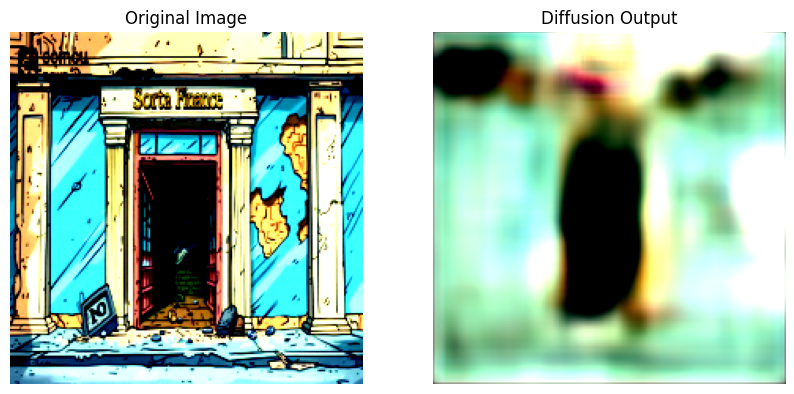

In [43]:
import torch
import matplotlib.pyplot as plt

# Tải checkpoint và chuyển mô hình sang chế độ đánh giá
checkpoint_path = '/home/azureuser/dat/test/pytorch-stable-diffusion/Stable_difusion/sd/checkpoint/checkpoint_epoch_100_val_loss_1.0824.pth'
diffusion, optimizer, start_epoch, best_val_loss = load_checkpoint(diffusion, optimizer, checkpoint_path)
diffusion.eval()
device = "cuda"

with torch.no_grad():
    for batch_idx, batch in enumerate(train_loader):
        images = batch['image'].to(device)
        captions = batch['caption']

        # Xử lý captions sử dụng CLIPProcessor
        inputs = processor(text=captions, return_tensors="pt", padding=True, truncation=True).to(device)
        captions_tensor = inputs['input_ids']

        image_embeds = clip_model.get_text_features(captions_tensor)  # Shape: [batch_size, embed_dim]
        text_embeds = clip_model.get_text_features(captions_tensor)  # Shape: [batch_size, embed_dim]

        # Forward pass qua mô hình diffusion
        outputs = diffusion(image_embeds, text_embeds)
        break

# Hiển thị ảnh gốc
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
# Chuyển tensor từ định dạng (1, 3, 224, 224) thành (3, 224, 224)
original_image = images[0].permute(1, 2, 0).cpu()  # Sử dụng ảnh đầu tiên trong batch
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
# Chuyển tensor kết quả từ mô hình từ định dạng (1, 3, 224, 224) thành (3, 224, 224)
output_image = outputs[0].permute(1, 2, 0).cpu()  # Sử dụng ảnh đầu tiên trong batch
plt.imshow(output_image)
plt.title('Diffusion Output')
plt.axis('off')

plt.show()


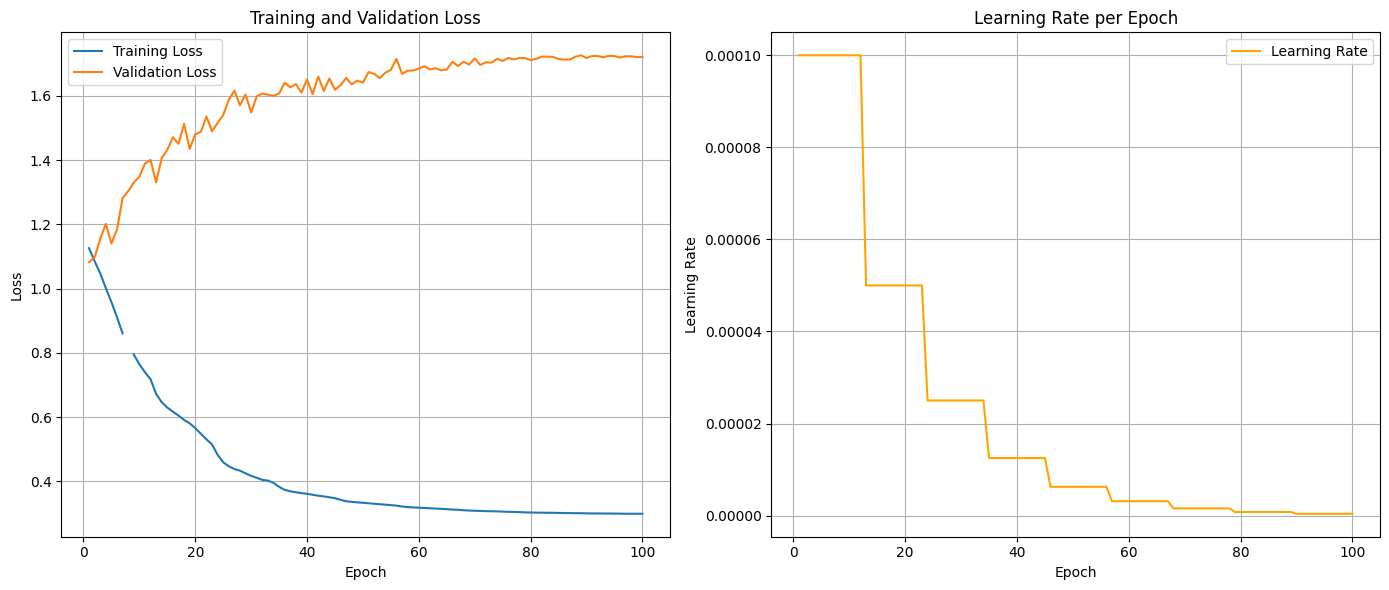

In [24]:
import matplotlib.pyplot as plt

# Đường dẫn tới file chứa dữ liệu loss và learning rate
file_path = '/home/azureuser/dat/test/pytorch-stable-diffusion/Stable_difusion/sd/checkpoint/losses_new.txt'

# Danh sách để lưu trữ các giá trị từ file
epochs = []
train_losses = []
val_losses = []
lrs = []

# Đọc dữ liệu từ file
with open(file_path, 'r') as file:
    for line in file:
        # Bỏ qua dòng nếu không đúng định dạng
        if ':' not in line or ',' not in line:
            continue
        
        try:
            # Tách dòng để lấy các giá trị cần thiết
            parts = line.strip().split(',')
            epoch = int(parts[0].split(' ')[1].strip())
            train_loss = float(parts[1].split(':')[1].strip())
            val_loss = float(parts[2].split(':')[1].strip())
            lr = float(parts[3].split(':')[1].strip())

            # Thêm các giá trị vào danh sách
            epochs.append(epoch)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            lrs.append(lr)
        
        except (IndexError, ValueError) as e:
            print(f"Error processing line: {line.strip()} - {e}")
            continue

# Kiểm tra xem có đủ dữ liệu để vẽ
if len(epochs) == 0:
    print("No valid data to plot.")
else:
    # Vẽ đồ thị loss theo epoch
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)

    # Vẽ đồ thị learning rate theo epoch
    plt.subplot(1, 2, 2)
    plt.plot(epochs, lrs, label='Learning Rate', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate per Epoch')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
